# Generalised Bernoulli map with various number formats

Revisiting BM Boghosian, PV Coveney, and H Wang. *A new pathology in the Simulation of Chaotic Dynamical Systems on Digital Computers*, **Adv. Theory Simul.** 2019, 2, 1900125, DOI: 10.1002/adts.201900125

### 0. Load packages

In [1]:
using PyPlot, FileIO, JLD2, Printf
using StochasticRounding, SoftPosit, LogFixPoint16s
using StatsBase, LinearAlgebra, Statistics
LogFixPoint16s.set_nfrac(10)   # use the 16-bit logfix format similar to Float16

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1278
┌ Info: Precompiling StochasticRounding [3843c9a1-1f18-49ff-9d99-1b4c8a8e97ed]
└ @ Base loading.jl:1278
┌ Warning: LogFixPoint16 was changed to 5 integer and 10 fraction bits.
└ @ LogFixPoint16s /Users/milan/.julia/packages/LogFixPoint16s/TGYbV/src/change_format.jl:25


### 1. Functions
Define the generalised Bernoulli map

$\quad x_{j+1} = f_\beta(x_j) = \beta x_j \mod 1$

with $\beta > 1$.

In [2]:
function bernoulli_orbit( x::T,            # initial condition
                          β::T,            # Bernoulli parameter
                          N0::Int,         # spin up iterations
                          N::Int) where T  # max period length
    oone = one(T)                  # 1 in format T
    
    # SPIN UP
    for i in 1:N0
        x = β*x
        x = x >= oone ? x-oone : x # x mod 1
    end
    
    # CHECK FOR PERIOD LENGTH
    x0 = x                         # new initial condition
    n = 0                          # orbit length (0 = not found yet)
    j = 0                          # iteration counter
    
    while n == 0 && j < N
        j += 1
        x = β*x
        x = x >= oone ? x-oone : x # x mod 1
        n = x0 == x ? j : 0        # check for periodicity
    end

    return n,x                     # return orbit length and last x that's on the orbit
end

bernoulli_orbit (generic function with 1 method)

In [3]:
function bernoulli_map(x::T,β::T,N::Int) where T
    oone = one(T)                  # 1 in format T
    xout = Array{T,1}(undef,N+1)   # preallocate
    xout[1] = x                    # store initial condition
    for i in 2:N+1
        x = β*x
        x = x >= oone ? x-oone : x # x mod 1
        xout[i] = x                # store iteration
    end
    return xout
end

bernoulli_map (generic function with 1 method)

In [4]:
# Hofbauer invariant measure h with C=1
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
h(x,β,N=100) = heaviside(1-x) + [β^-j for j in 1:N]'*heaviside.(bernoulli_map(1e0,β,N)[2:end] .- x)

h (generic function with 2 methods)

In [11]:
using RandomNumbers

function find_orbits(   ::Type{T},                  # Number format
                        β::Real;                    # Bernoulli parameter
                        n::Int=100000,              # n initial conditions
                        N0::Int=50000,              # spinup
                        Nmax::Int=1000000) where T  # maximum orbit length

    println("β = $β, $T")
    
    O = fill(0,n)           # array of orbit period lengths for each IC
    X = Array{T}(undef,n)   # for each orbit one x on the orbit

    for i in 1:n            # for n ICs calculate orbit lengths & x
#         subnormal = reinterpret(Float32,rand(1:Int(reinterpret(UInt32,floatmin(Float32)))) % UInt32)
#         f = reinterpret(Float32,rand(1:Int(reinterpret(UInt32,one(Float32)))) % UInt32)
#         f = rand(Float32)/10+0.9
#         f = Float32(reinterpret(Float64,Base.exponent_half(Float64) | Base.significand_mask(Float64) & rand(UInt64)))
#         f = T(rand(RNG,Float64))
        f = randfloat(T)
        O[i],X[i] = bernoulli_orbit(f,T(β),N0,Nmax)
#         O[i],X[i] = bernoulli_orbit(rand(RNG,T),T(β),N0,Nmax)
    end

    # find unique orbit lengths via Set
    orbit_lengths = sort([o for o in Set(O)])
    
    # preallocate
    orbit_x0 = fill(zero(T),length(orbit_lengths))
    orbit_p = fill(0.0,length(orbit_lengths))

    iol = 1
    for ol in orbit_lengths

        # all x for orbit length ol, use as initial condition
        Xini = X[O .== ol]
        p = length(Xini)/n   # size of the basin of attraction
        x0s = T[]            # array of min x to identify unique orbits
                             # if >1 orbit exists with same length length(x0s)>1

        for x in Xini        # per IC calculate all points on that orbit
            xorbit = bernoulli_map(x,T(β),ol)
            mx = minimum(xorbit)
            if ~(mx in x0s)
                x0s = vcat(x0s,mx)
            end
        end
        
        orbit_x0[iol] = x0s[1]
        orbit_p[iol] = p
    
        # print orbit informtation
        s1 = "Orbit $(@sprintf("%2d",iol)): length = $(@sprintf("%6d",ol)), "
        s2 = "x₀ = $(@sprintf("%16s",repr(x0s[1]))), "
        s3 = "p = $(@sprintf("%.6f",p))"
        println(s1*s2*s3)
        iol += 1
        
        # in case there are several orbits of same period length, print their info
        if length(x0s) > 1
            for x0 in x0s[2:end]
                s1 = "Orbit $(@sprintf("%2d",iol)): length = $(@sprintf("%6d",ol)), "
                s2 = "x₀ = $(@sprintf("%16s",repr(x0)))"
                println(s1*s2)
                iol += 1
            end
        end
    end
    
    return orbit_lengths,orbit_x0,orbit_p
end

find_orbits (generic function with 1 method)

In [6]:
ol1,ox1,op1 = find_orbits(Float32,3//2,n=1000000);

β = 3//2, Float32
Orbit  1: length =      1, x₀ =            0.0f0, p = 0.000001
Orbit  2: length =      4, x₀ =     0.24615383f0, p = 0.000002
Orbit  3: length =      5, x₀ =     0.15165877f0, p = 0.000001
Orbit  4: length =     19, x₀ =     0.06243241f0, p = 0.009443
Orbit  5: length =     39, x₀ =    0.010771394f0, p = 0.000006
Orbit  6: length =     69, x₀ =   0.0052359104f0, p = 0.000394
Orbit  7: length =     86, x₀ =    0.037434578f0, p = 0.000702
Orbit  8: length =    285, x₀ =    0.008414507f0, p = 0.000765
Orbit  9: length =    297, x₀ =     5.2928925f-5, p = 0.008612
Orbit 10: length =    313, x₀ =      6.747246f-5, p = 0.006192
Orbit 11: length =    445, x₀ =   0.0024217367f0, p = 0.001142
Orbit 12: length =    494, x₀ =   0.0057212114f0, p = 0.046561
Orbit 13: length =    517, x₀ =   0.0037292242f0, p = 0.045127
Orbit 14: length =    982, x₀ =    0.002391696f0, p = 0.061636
Orbit 15: length =   5228, x₀ =     4.1007996f-5, p = 0.819416


In [16]:
ol2,ox2,op2 = find_orbits(Float32,5//4,n=100000);
ol3,ox3,op3 = find_orbits(Float32,4//3,n=100000);
ol4,ox4,op4 = find_orbits(Float32,6//5,n=100000);

β = 5//4, Float32
Orbit  1: length =    137, x₀ =   0.0072830915f0, p = 0.004080
Orbit  2: length =    219, x₀ =    0.005312443f0, p = 0.000630
Orbit  3: length =    228, x₀ =   0.0007648468f0, p = 0.002600
Orbit  4: length =   2117, x₀ =  0.00061380863f0, p = 0.018270
Orbit  5: length =   3763, x₀ =   0.0009752512f0, p = 0.974420
β = 4//3, Float32
Orbit  1: length =      1, x₀ =            0.0f0, p = 0.002900
Orbit  2: length =     48, x₀ =     0.06936097f0, p = 0.000050
Orbit  3: length =     49, x₀ =    0.048506975f0, p = 0.000280
Orbit  4: length =    153, x₀ =      0.0189718f0, p = 0.000490
Orbit  5: length =    336, x₀ =   0.0012991428f0, p = 0.019260
Orbit  6: length =   3304, x₀ =  0.00014281273f0, p = 0.463910
Orbit  7: length =   4790, x₀ =   0.0004069805f0, p = 0.513110
β = 6//5, Float32
Orbit  1: length =    135, x₀ =    0.008523345f0, p = 0.014370
Orbit  2: length =    329, x₀ =   0.0030605793f0, p = 0.003920
Orbit  3: length =    792, x₀ =   0.0016326904f0, p = 0.008100
O

In [7]:
ol2,ox2,op2 = find_orbits(Float32,Xoroshiro128P,5//4,n=1000000);
ol3,ox3,op3 = find_orbits(Float32,Xoroshiro128P,4//3,n=1000000);
ol4,ox4,op4 = find_orbits(Float32,Xoroshiro128P,6//5,n=1000000);

β = 5//4, Float32
Orbit  1: length =     12, x₀ =     0.07379031f0, p = 0.000018
Orbit  2: length =    137, x₀ =   0.0072830915f0, p = 0.004292
Orbit  3: length =    219, x₀ =    0.005312443f0, p = 0.000653
Orbit  4: length =    228, x₀ =   0.0007648468f0, p = 0.002686
Orbit  5: length =   2117, x₀ =  0.00061380863f0, p = 0.018153
Orbit  6: length =   3763, x₀ =   0.0009752512f0, p = 0.974198
β = 4//3, Float32
Orbit  1: length =      1, x₀ =            0.0f0, p = 0.003007
Orbit  2: length =      6, x₀ =     0.21651316f0, p = 0.000005
Orbit  3: length =     48, x₀ =     0.06936097f0, p = 0.000112
Orbit  4: length =     49, x₀ =    0.048506975f0, p = 0.000256
Orbit  5: length =    153, x₀ =      0.0189718f0, p = 0.000323
Orbit  6: length =    336, x₀ =   0.0012991428f0, p = 0.019551
Orbit  7: length =   3304, x₀ =  0.00014281273f0, p = 0.463057
Orbit  8: length =   4790, x₀ =   0.0004069805f0, p = 0.513689
β = 6//5, Float32
Orbit  1: length =     16, x₀ =    0.057180643f0, p = 0.000002
O

In [30]:
# bins
βs = [3/2,5/4,4/3,6/5]                                                
nβs = length(βs)
bin_width = 2.5e-2
bin_edges = collect(0:bin_width:1)
nbins = length(bin_edges)-1

# preallocate all histograms
norbits = 4   # 1, 1&2, 1&2&3, all
Histow = fill(0.0,nβs,norbits,nbins)

oxx = [ox1,ox2,ox3,ox4]
oll = [ol1,ol2,ol3,ol4]
opp = [op1,op2,op3,op4]

for (iβ,β) in enumerate(βs)
    ox = oxx[iβ]
    ol = oll[iβ]
    op = opp[iβ]
    nol = length(ol)
    
    Histos = fill(0.0,nol,nbins)
    
    for io in 1:nol
        X = bernoulli_map(ox[io],Float32(β),ol[io]-1)
        H = fit(Histogram,X,bin_edges).weights
        Histos[io,:] = H / sum(H) / bin_width
    end

    # weighted means
    Histow[iβ,1,:] = Histos[end,:]
    Histow[iβ,2,:] = mean(Histos[end-1:end,:],weights(op[end-1:end]),dims=1)
    Histow[iβ,3,:] = mean(Histos[end-2:end,:],weights(op[end-2:end]),dims=1)
    Histow[iβ,4,:] = mean(Histos,weights(op),dims=1)
end

In [32]:
# Sample analytical invariant measure at bins
hxs = fill(0.0,nβs,nbins)
x = collect(0:1e-6:1)

for (iβ,β) in enumerate(βs)
    H = [sum(h.(x[(x .>= bin_edges[i]) .& (x .< bin_edges[i+1])],β)) for i in 1:nbins]
    hxs[iβ,:] = H / sum(H) / bin_width
end

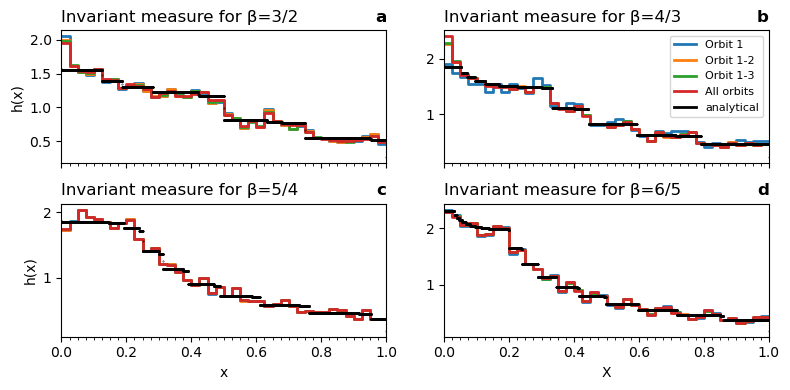

In [36]:
# PLOT
fig,axs = subplots(2,2,sharex=true,figsize=(8,4))

for (iax,ax) in enumerate(axs)
    H = Histow[iax,1,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Orbit 1")
    
    H = Histow[iax,2,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Orbit 1-2")
    
    H = Histow[iax,3,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Orbit 1-3")
    
    H = Histow[iax,4,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="All orbits")
    
    # Add analytical invariant measures from Hofbauer (binned version)
#     H = hxs[iax,:]
#     ax.plot(bin_edges,vcat(H[1],H),"k",ds="steps-pre",lw=2,label="analytical")
end

# Add analytical invariant measures from Hofbauer
x = collect(0:1e-4:1)
for (iβ,β) in enumerate(βs)
    hx = h.(x,β)
    axs[iβ].scatter(x,hx/sum(hx*(x[2]-x[1])),0.1,color="k",zorder=10)
    # only for legend (plot outside xlim,ylim)
    axs[iβ].plot(-x,hx/sum(hx*(x[2]-x[1])),"k",lw=2,label="analytical")
end

for (iβ,β) in enumerate(["3/2","5/4","4/3","6/5"])
    axs[iβ].set_title("Invariant measure for β=$β",loc="left")
end

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,2].legend(loc=1,fontsize=8)

axs[1,1].set_ylabel("h(x)")
axs[2,1].set_ylabel("h(x)")
axs[2,1].set_xlabel("x")
axs[2,2].set_xlabel("X")
axs[1,1].set_xlim(0,1)
axs[1,1].set_xticks(bin_edges,minor=true)

tight_layout()
savefig("../plots/inv_measures_orbits.png")

## 2. Comparison to Monte Carlo-based invariant measures

In [28]:
# Calculate histograms
Nens_size = [10,100,1000,10000]   # start from Nens random initial conditions
Nsteps = 20000           # integrate for Nsteps time steps
Nspinup = 5000           # discard Nspinsup time steps

# each for different β
βs = [3/2,5/4,4/3,6/5]                                                
Nβs = length(βs)
Nenssizes = length(Nens_size)

# bins
bin_width = 2.5e-2
bin_edges = collect(0:bin_width:1)
nbins = length(bin_edges)-1

# preallocate all histograms
Histos = fill(0.0,Nenssizes,Nβs,nbins)

for (inens,Nens) in enumerate(Nens_size)
    for (iβ,β) in enumerate(βs)
        X = fill(0.0,Nens,Nsteps)
        for iens in 1:Nens
            f = randfloat(Float32)
            X[iens,:] = bernoulli_map(f,Float32(β),Nsteps+Nspinup)[Nspinup+2:end]
        end
        H = fit(Histogram,vec(X),bin_edges).weights
        Histos[inens,iβ,:] = H / sum(H) / bin_width
    end
end 

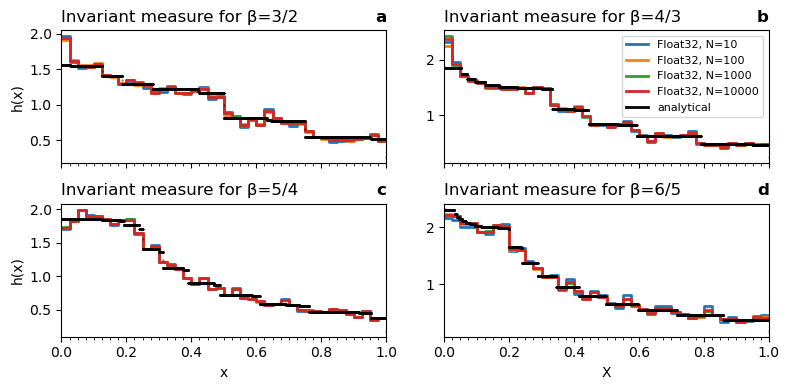

In [29]:
# PLOT
fig,axs = subplots(2,2,sharex=true,figsize=(8,4))

for (iax,ax) in enumerate(axs)
    H = Histos[1,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32, N=10")
    
    H = Histos[2,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32, N=100")
    
    H = Histos[3,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32, N=1000")
    
    H = Histos[4,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32, N=10000")
end


# Add analytical invariant measures from Hofbauer
x = collect(0:1e-4:1)
for (iβ,β) in enumerate(βs)
    hx = h.(x,β)
    axs[iβ].scatter(x,hx/sum(hx*(x[2]-x[1])),0.1,color="k",zorder=10)
    # only for legend (plot outside xlim,ylim)
    axs[iβ].plot(-x,hx/sum(hx*(x[2]-x[1])),"k",lw=2,label="analytical")
end

for (iβ,β) in enumerate(["3/2","5/4","4/3","6/5"])
    axs[iβ].set_title("Invariant measure for β=$β",loc="left")
end

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,2].legend(loc=1,fontsize=8)

axs[1,1].set_ylabel("h(x)")
axs[2,1].set_ylabel("h(x)")
axs[2,1].set_xlabel("x")
axs[2,2].set_xlabel("X")
axs[1,1].set_xlim(0,1)
axs[1,1].set_xticks(bin_edges,minor=true)

tight_layout()
# savefig("../plots/inv_measures.png")